# 과제 1
 - 오늘 배운 모델 (VGG, GoogLe, Res 등) 아무거나 활용해서 Caltech101 데이터를 학습하고 테스트 해보세요

## 1. Data Pre-Processing

### 1-1. Read Data 

In [0]:
import os
import cv2
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import random
from tqdm import tqdm

In [3]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount = True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
%%time
X=[]
y=[]
path='/content/gdrive/My Drive/Colab Notebooks/101_ObjectCategories'
category_list=os.listdir(path)
for category in tqdm(category_list):
    imges=os.listdir(path+'/'+category)
    for img in imges:
        data=cv2.imread(path+'/'+category+'/'+img)
        data=cv2.resize(data,(224,224))
        label=category
        X.append(data)
        y.append(label)
X=np.array(X)
y=np.array(y)

100%|██████████| 102/102 [00:32<00:00,  4.69it/s]


CPU times: user 13.2 s, sys: 3.73 s, total: 16.9 s
Wall time: 33.4 s


In [0]:
encoder=LabelEncoder()
labels=encoder.fit_transform(y)

In [4]:
from keras.utils import to_categorical
display(labels.shape)
labels = to_categorical(labels, num_classes=None)
display(labels.shape)

Using TensorFlow backend.


(9155,)

(9155, 102)

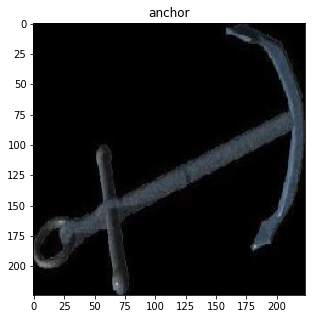

In [5]:
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
plt.figure(figsize=(5,5))
plt.imshow(X[0])
plt.title(y[0])
plt.show()

### 1-2 Processing

In [0]:
X= X/255

In [0]:
from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X,labels,test_size=0.2,random_state=7)
train_data, validation_data, train_label, validation_label = train_test_split(X,labels,test_size=0.2,random_state=7)

In [0]:
del X

In [0]:
#Augmentation
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images

datagen.fit(train_data)

________

## 2. Modeling

### 2-1. ResNet

In [0]:
from keras import models, layers
from keras import Input
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, initializers, regularizers, metrics
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import BatchNormalization, Conv2D, Activation, Dense, GlobalAveragePooling2D, MaxPooling2D, ZeroPadding2D, Add
from keras import optimizers
from keras.optimizers import adam
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

### Just ResNet ( Not Trained )

In [11]:
resnet_not_trained=ResNet50(include_top=True,input_shape=(224,224,3))








102858752/102853048 [==============================] - 4s 0us/step


In [12]:
resnet_not_trained.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [13]:
model = models.Sequential()
model.add(resnet_not_trained)
model.add(layers.Dense(102,activation = 'softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 1000)              25636712  
_________________________________________________________________
dense_1 (Dense)              (None, 102)               102102    
Total params: 25,738,814
Trainable params: 25,685,694
Non-trainable params: 53,120
_________________________________________________________________


In [14]:
model.compile(loss = 'categorical_crossentropy',
             optimizer = adam(),
             metrics = ['acc'])

In [15]:
batch_size = 32

history = model.fit_generator(datagen.flow(train_data, train_label,
                                           batch_size=batch_size),
                              steps_per_epoch= (train_data.shape[0] // batch_size),
                              epochs = 50,
                              validation_data=(validation_data,validation_label))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/50
228/228 [==============================] - 118s 519ms/step - loss: 4.5322 - acc: 0.1267 - val_loss: 4.4777 - val_acc: 0.0595
Epoch 2/50
228/228 [==============================] - 102s 449ms/step - loss: 4.3901 - acc: 0.1263 - val_loss: 4.3300 - val_acc: 0.1081
Epoch 3/50
228/228 [==============================] - 102s 449ms/step - loss: 4.2858 - acc: 0.1268 - val_loss: 4.2913 - val_acc: 0.0890
Epoch 4/50
228/228 [==============================] - 102s 449ms/step - loss: 4.1755 - acc: 0.1342 - val_loss: 4.2077 - val_acc: 0.1076
Epoch 5/50
228/228 [==============================] - 102s 449ms/step - loss: 4.1172 - acc: 0.1306 - val_loss: 4.1312 - val_acc: 0.1109
Epoch 6/50
228/228 [==============================] - 102s 448ms/step - loss: 4.0420 - acc: 0.1412 - val_loss: 4.1054 - val_acc: 0.1344
Epoch 7/50
228/228 [==============================] - 102s 447ms/step - loss: 3.9967 - acc

Train loss, Validation loss 모두 천천히 줄어든다 ( 에폭을 더 돌리면, 더 줄일 수 있을듯)

3.1 Transfer Learning

In [0]:
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

In [17]:
resnet = ResNet50(weights = 'imagenet', include_top = False, input_shape = (224,224,3))

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 3s 0us/step


In [21]:
model = models.Sequential()
model.add(resnet)
model.add(layers.Flatten())
model.add(layers.Dense(102,activation = 'softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_2 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 102)               10236006  
Total params: 33,823,718
Trainable params: 10,236,006
Non-trainable params: 23,587,712
_________________________________________________________________


In [19]:
# resnet를 동결
print('resnet 동결하기 전 훈련되는 레이어의 수 :',len(model.trainable_weights))
resnet.trainable = False
print('resnet을 동결한 후 훈련되는 레이어의 수:',len(model.trainable_weights))

resnet 동결하기 전 훈련되는 레이어의 수 : 216
resnet을 동결한 후 훈련되는 레이어의 수: 4


In [22]:
model.compile(loss = 'categorical_crossentropy',
             optimizer = adam(),
             metrics = ['acc'])
batch_size = 32

history = model.fit_generator(datagen.flow(train_data, train_label,
                                           batch_size=batch_size),
                              steps_per_epoch= (train_data.shape[0] // batch_size),
                              epochs = 50,
                              validation_data=(validation_data,validation_label))

Epoch 1/50
228/228 [==============================] - 76s 335ms/step - loss: 10.5572 - acc: 0.3373 - val_loss: 16.0477 - val_acc: 0.0044
Epoch 2/50
228/228 [==============================] - 72s 314ms/step - loss: 10.2326 - acc: 0.3626 - val_loss: 16.0477 - val_acc: 0.0044
Epoch 3/50
228/228 [==============================] - 72s 314ms/step - loss: 10.0906 - acc: 0.3713 - val_loss: 15.0799 - val_acc: 0.0481
Epoch 4/50
228/228 [==============================] - 71s 313ms/step - loss: 9.4739 - acc: 0.4101 - val_loss: 15.9992 - val_acc: 0.0049
Epoch 5/50
228/228 [==============================] - 71s 312ms/step - loss: 9.5288 - acc: 0.4063 - val_loss: 16.0190 - val_acc: 0.0044
Epoch 6/50
228/228 [==============================] - 70s 308ms/step - loss: 9.3274 - acc: 0.4195 - val_loss: 16.0356 - val_acc: 0.0044
Epoch 7/50
228/228 [==============================] - 70s 305ms/step - loss: 9.2072 - acc: 0.4274 - val_loss: 16.0115 - val_acc: 0.0049
Epoch 8/50
228/228 [=========================

Train Accuracy는 높은데 Val_acc는 참담